# Notebook 1: Feature Engineering for electroencephalogram (EEG) signals

The dataset consists of one-second recordings of electroencephalogram (EEG) activity, collected both during epileptic seizures and during normal brain activity. These two states are labeled as $1$ and $0$ in the `y` column, respectively. 

The construction of the dataset introduces a fundamental issue when formulating the classification task under the assumption that the feature space is structured as a time series. Specifically, for different recordings, the feature $X_i$, which corresponds to the $\frac{1}{i}^{\text{th}}$ second of the recording, may represent distinct stages of brain activity. For example, in a given row, $X_4$ could correspond to the onset of an epileptic seizure, whereas in another row, it could represent its conclusion. The fact that features don't have a synchronized reference point makes their meaning inconsistent.

To address this issue, we will map the original dataset into a new feature space defined by holistic characteristics of the time series, which are "time homogeneous" (not really but couldn't find a better word). The features we will introduce will go from statistical descriptors to signal processing specifics.


In [18]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from scipy.signal import welch
from scipy.stats import skew, kurtosis
import pywt

In [19]:
# Load dataset
df = pd.read_csv(
    "data" + "\\Epileptic Seizure Recognition.csv", index_col=0
).reset_index(drop=True)
df.head()

# transform target variable to reduce into a binary classification problem
# y \in {1: seizure, 0: no seizure}
df["y"] = df["y"].apply(lambda x: 0 if x != 1 else 1)
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


In [20]:
X = df.drop("y", axis=1)
y = df["y"]

### Time Domain features

Let's plot one random signal.

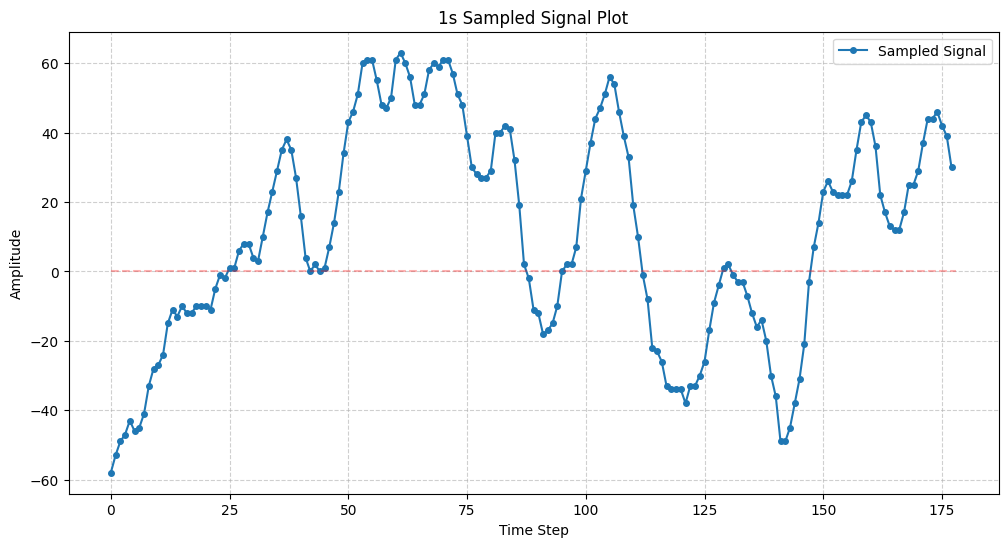

In [21]:
# Sample a signal from X
signal = X.sample(1).values.flatten()  # Flatten in case of multidimensional output

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(
    np.arange(len(signal)),
    signal,
    marker="o",
    linestyle="-",
    markersize=4,
    label="Sampled Signal",
)

# Improve aesthetics
plt.xlabel("Time Step")
plt.ylabel("Amplitude")
plt.title("1s Sampled Signal Plot")
plt.hlines(0, 0, len(signal), linestyles="dashed", colors="r", alpha=0.3)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

This graph is called the `time-domain` signal and shows how the amplitude of the signal changes over time. From this graph we will extract some standard statistics that will help characterise the signal. We explain the less common ones below.

In [22]:
def extract_time_domain_features(signal: pd.Series) -> pd.Series:
    features = {}

    # Basic Statistics
    features["mean"] = np.mean(signal)
    features["std"] = np.std(signal, ddof=1)
    features["var"] = np.var(signal, ddof=1)
    features["min"] = np.min(signal)
    features["max"] = np.max(signal)
    features["skew"] = skew(signal)
    features["kurtosis"] = kurtosis(signal)
    features["rms"] = np.sqrt(np.mean(signal**2))
    features["zero_crossings"] = len(np.where(np.diff(np.signbit(signal)))[0])

    # Maximum absolute value
    features["abs_max"] = np.max(np.abs([features["min"], features["max"]]))

    # Factors
    features["crest_factor"] = features["abs_max"] / features["rms"]
    features["margin_factor"] = features["abs_max"] / features["var"]
    features["shape_factor"] = features["rms"] / (np.mean(np.abs(signal)))
    features["impulse_factor"] = features["abs_max"] / (np.mean(np.abs(signal)))

    return pd.Series(features)

The **crest factor** is defined as the ratio of the absolute maximum value of a signal to its RMS value:

$$
C(y_n) = \frac{\max |y_n|}{RMS(y_n)} \qquad \text{where } RMS{(y_n)} = \sqrt{\frac{1}{N} \sum_{n=1}^N y_n^2},
$$

This represents how large the highest peak is relative to the average power of the signal. It provides a measure of the extremity of peaks in the signal compared to its overall energy.

The **margin factor** is conceptually similar but compares the absolute maximum value to the variance of the signal:

$$
M = \frac{\max |y_n|}{\text{Var}(y_n)}, \qquad \text{where } \text{Var}(y_n) = \frac{1}{N} \sum_{n=1}^N \left( y_n - \bar{y} \right)^2
$$

This reflects the size of the highest peak relative to the dispersion (variance) of the signal. The reader may observe that when the mean of the signal is zero, for example in a white noise, the crest factor and margin factor coincide as the variance is the RMS centered in the mean, 0 in this case.

The **shape factor** measures how the RMS value compares to the Mean Absolute Value (MAV). This metric rather than quantifying the maximum peak like the former one, it characterises the amount of peaks and their intensity. Note that the higher the peaks the highest the differenc between its squared value and its absolute one, so the fractio increases.

$$
S(y_n) = \frac{\text{RMS}}{\text{MAV}},  \quad \text{MAV} = \frac{1}{N} \sum_{n=1}^N |y_n|
$$

The **impulse factor** is another related measure, comparing the absolute maximum value to the MAV. Similarly, the impulse factor highlights the dominance of a signal’s highest peak compared to its typical magnitude.


$$
I = \frac{\max |y_n|}{\text{MAV}}
$$


In [23]:
features_df = pd.DataFrame()
features_df = X.apply(extract_time_domain_features, axis=1)
features_df

,mean,std,var,min,max,skew,kurtosis,rms,zero_crossings,abs_max,crest_factor,margin_factor,shape_factor,impulse_factor
0,-16.910112,95.980947,9212.342157,-281.0,229.0,-0.200327,0.067411,97.193309,23.0,281.0,2.891146,0.030503,1.256019,3.631334
1,28.112360,473.166815,223886.834762,-1716.0,513.0,-1.511088,1.341888,472.672559,8.0,1716.0,3.630420,0.007665,1.258349,4.568335
2,-44.044944,44.311025,1963.466895,-126.0,80.0,0.494485,-0.240414,62.389048,12.0,126.0,2.019585,0.064172,1.157038,2.336737
3,-68.910112,15.968642,254.997524,-105.0,-22.0,0.367125,0.212160,70.726010,0.0,105.0,1.484602,0.411769,1.026352,1.523724
4,-6.651685,38.802149,1505.606805,-103.0,78.0,-0.462741,-0.250516,39.260581,32.0,103.0,2.623497,0.068411,1.269692,3.331032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,5.157303,38.376487,1472.754777,-79.0,73.0,-0.185539,-0.966425,38.614488,8.0,79.0,2.045864,0.053641,1.167354,2.388247
11496,5.674157,163.538573,26744.864978,-388.0,471.0,0.009039,0.523230,163.177232,11.0,471.0,2.886432,0.017611,1.295173,3.738429
11497,6.752809,44.289439,1961.554371,-90.0,121.0,0.092115,-0.410145,44.678125,25.0,121.0,2.708260,0.061686,1.238739,3.354829
11498,-38.842697,63.607269,4045.884720,-157.0,148.0,0.519187,0.272000,74.376812,9.0,157.0,2.110873,0.038805,1.224933,2.585677


### Frequency Domain features

In [24]:
def extract_frequency_domain_features(row, fs=178):
    """Extract Spectral Power Density (PSD) features from a row of a signal."""

    features = {}

    # Compute Power Spectral Density using Welch's method.
    freqs, psd = welch(row, fs=fs, nperseg=len(row))

    # Helper function to compute band power using integration.
    def bandpower(psd, freqs, fmin, fmax):
        idx = np.logical_and(freqs >= fmin, freqs <= fmax)
        area = np.trapz(psd[idx], freqs[idx])  # integrate along freq axis
        return area

    # Define typical EEG frequency bands (Hz)
    features["delta_power"] = bandpower(psd, freqs, 0.5, 4)
    features["theta_power"] = bandpower(psd, freqs, 4, 8)
    features["alpha_power"] = bandpower(psd, freqs, 8, 13)
    features["beta_power"] = bandpower(psd, freqs, 13, 30)
    features["gamma_power"] = bandpower(psd, freqs, 30, fs / 2)

    return pd.Series(features)

In [25]:
features_df_bis = pd.DataFrame()
features_df_bis = X.apply(extract_frequency_domain_features, axis=1)
features_df = pd.concat([features_df, features_df_bis], axis=1)
features_df

,mean,std,var,min,max,skew,kurtosis,rms,zero_crossings,abs_max,crest_factor,margin_factor,shape_factor,impulse_factor,delta_power,theta_power,alpha_power,beta_power,gamma_power
0,-16.910112,95.980947,9212.342157,-281.0,229.0,-0.200327,0.067411,97.193309,23.0,281.0,2.891146,0.030503,1.256019,3.631334,2531.504216,154.681371,3184.617042,5194.059337,90.945865
1,28.112360,473.166815,223886.834762,-1716.0,513.0,-1.511088,1.341888,472.672559,8.0,1716.0,3.630420,0.007665,1.258349,4.568335,141647.645956,64889.280488,24660.943649,29545.678976,547.575979
2,-44.044944,44.311025,1963.466895,-126.0,80.0,0.494485,-0.240414,62.389048,12.0,126.0,2.019585,0.064172,1.157038,2.336737,288.399389,311.355507,300.520181,486.184900,13.772599
3,-68.910112,15.968642,254.997524,-105.0,-22.0,0.367125,0.212160,70.726010,0.0,105.0,1.484602,0.411769,1.026352,1.523724,69.356387,28.827769,57.394592,73.146142,6.538426
4,-6.651685,38.802149,1505.606805,-103.0,78.0,-0.462741,-0.250516,39.260581,32.0,103.0,2.623497,0.068411,1.269692,3.331032,221.391774,127.496323,146.549196,322.243315,35.546279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,5.157303,38.376487,1472.754777,-79.0,73.0,-0.185539,-0.966425,38.614488,8.0,79.0,2.045864,0.053641,1.167354,2.388247,412.564908,453.516933,122.380570,11.106535,4.966532
11496,5.674157,163.538573,26744.864978,-388.0,471.0,0.009039,0.523230,163.177232,11.0,471.0,2.886432,0.017611,1.295173,3.738429,1899.417992,10204.530106,4096.579741,2273.298170,37.826039
11497,6.752809,44.289439,1961.554371,-90.0,121.0,0.092115,-0.410145,44.678125,25.0,121.0,2.708260,0.061686,1.238739,3.354829,453.110904,75.283150,143.449374,762.980044,131.436605
11498,-38.842697,63.607269,4045.884720,-157.0,148.0,0.519187,0.272000,74.376812,9.0,157.0,2.110873,0.038805,1.224933,2.585677,578.777539,471.312377,866.189851,189.770426,17.173990


In [26]:
def extract_wavelet_nonlinear_features(signal):
    """Extract Wavelet Transform and Non-Linear (Approximate Entropy) features from a signal."""
    features = {}

    # Decompose the signal using the Discrete Wavelet Transform.
    # 'db4' is a commonly used wavelet for EEG.
    coeffs = pywt.wavedec(signal, "db4", level=4)
    for i, coeff in enumerate(coeffs):
        features[f"wavelet_energy_level_{i}"] = np.sum(np.square(coeff))

    # === Non-Linear Features: Approximate Entropy ===
    def approximate_entropy(U, m, r):
        """Compute approximate entropy of a time series U."""
        N = len(U)

        def _phi(m):
            # Create a list of vectors of length m.
            x = np.array([U[i : i + m] for i in range(N - m + 1)])
            # Compute the Chebyshev distance between vectors.
            C = np.sum(np.max(np.abs(x[:, None] - x[None, :]), axis=2) <= r, axis=0) / (
                N - m + 1
            )
            # Avoid log(0) by replacing zeros with a small constant.
            C[C == 0] = 1e-10
            return np.sum(np.log(C)) / (N - m + 1)

        return _phi(m) - _phi(m + 1)

    # Set the tolerance parameter based on the standard deviation of the signal.
    r = 0.2 * np.std(signal)
    try:
        features["approx_entropy"] = approximate_entropy(signal, m=2, r=r)
    except Exception as e:
        features["approx_entropy"] = np.nan

    return pd.Series(features)

In [27]:
features_df_bis = pd.DataFrame()
features_df_bis = X.apply(extract_wavelet_nonlinear_features, axis=1)

features_df = pd.concat([features_df, features_df_bis], axis=1)

features_df

,mean,std,var,min,max,skew,kurtosis,rms,zero_crossings,abs_max,...,theta_power,alpha_power,beta_power,gamma_power,wavelet_energy_level_0,wavelet_energy_level_1,wavelet_energy_level_2,wavelet_energy_level_3,wavelet_energy_level_4,approx_entropy
0,-16.910112,95.980947,9212.342157,-281.0,229.0,-0.200327,0.067411,97.193309,23.0,281.0,...,154.681371,3184.617042,5194.059337,90.945865,3.690802e+06,1.535263e+05,7.258087e+05,1.070282e+05,7569.491844,0.674851
1,28.112360,473.166815,223886.834762,-1716.0,513.0,-1.511088,1.341888,472.672559,8.0,1716.0,...,64889.280488,24660.943649,29545.678976,547.575979,2.982845e+07,1.164573e+07,6.569807e+06,2.279285e+06,74217.980651,0.321345
2,-44.044944,44.311025,1963.466895,-126.0,80.0,0.494485,-0.240414,62.389048,12.0,126.0,...,311.355507,300.520181,486.184900,13.772599,5.954840e+05,9.436542e+04,1.429052e+05,1.860976e+04,1716.899579,0.757659
3,-68.910112,15.968642,254.997524,-105.0,-22.0,0.367125,0.212160,70.726010,0.0,105.0,...,28.827769,57.394592,73.146142,6.538426,1.686014e+06,1.825810e+04,1.450674e+04,2.511453e+03,813.688912,0.880430
4,-6.651685,38.802149,1505.606805,-103.0,78.0,-0.462741,-0.250516,39.260581,32.0,103.0,...,127.496323,146.549196,322.243315,35.546279,5.950417e+05,5.298987e+04,7.528144e+04,3.773313e+04,2503.114777,0.692749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,5.157303,38.376487,1472.754777,-79.0,73.0,-0.185539,-0.966425,38.614488,8.0,79.0,...,453.516933,122.380570,11.106535,4.966532,2.975380e+05,5.223182e+04,1.085729e+04,1.632096e+03,302.940919,0.611491
11496,5.674157,163.538573,26744.864978,-388.0,471.0,0.009039,0.523230,163.177232,11.0,471.0,...,10204.530106,4096.579741,2273.298170,37.826039,1.489779e+06,5.494694e+06,2.889903e+05,5.831723e+04,1831.618674,0.451915
11497,6.752809,44.289439,1961.554371,-90.0,121.0,0.092115,-0.410145,44.678125,25.0,121.0,...,75.283150,143.449374,762.980044,131.436605,2.063650e+05,2.196174e+04,8.364039e+04,4.213575e+04,9743.504069,0.913582
11498,-38.842697,63.607269,4045.884720,-157.0,148.0,0.519187,0.272000,74.376812,9.0,157.0,...,471.312377,866.189851,189.770426,17.173990,8.424921e+05,1.486457e+05,5.561382e+04,1.275353e+04,2016.948235,0.611124


In [28]:
transformed_df = pd.concat([features_df, y], axis=1)
transformed_df.to_csv("transformed_df.csv", index=0)